In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


### Monitoring and CUDA Setup


In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/10_epochs_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_18_2024_224407'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Config for RPN and ViT Fitter


In [4]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        # pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.0001
}

324


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=16,
        dim_ff=1600
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

### Dataset Loading


In [6]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [7]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [8]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### RPN Fitter


In [9]:
from project import Fitter

In [10]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

### ViT Fitter


In [11]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader, stage1)
            val_loss, val_metric = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                with torch.inference_mode():
                    x, t = stage1(slices, masks, target)
                
                # self.log(f'{x.requires_grad}, {t.requires_grad}')
                # self.log(f'{x.shape}, {t.shape}')

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [12]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [13]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [14]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001212B4E5190>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001212B485910>
ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001212B427290>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001212B4875D0>


In [15]:
rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [16]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [18]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 16

In [19]:
rpn_test_iou = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []

vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [20]:
rpn_fold_metrics = []
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    
    # RPN
    rpn_config['model'] = RPN(
        input_dim=512,
        output_dim=4,
        image_size=image_size,
        nh=4,
    ).to(device)
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_train_subset = Subset(rpn_train_set, train_index)
    rpn_val_subset = Subset(rpn_train_set, val_index)
    
    rpn_train_subset_dl = DataLoader(
        rpn_train_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    rpn_val_subset_dl = DataLoader(
        rpn_val_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    rpn_thist, rpn_vhist, rpn_tmhist, rpn_vmhist = rpn_fitter.fit(rpn_train_subset_dl, rpn_val_subset_dl)
    
    rpn_fold_metrics.append({
        'fold': i + 1,
        'training_history': rpn_thist,
        'validation_history': rpn_vhist,
        'training_metrics': rpn_tmhist,
        'validation_metrics': rpn_vmhist
    })
    
    rpn_h, rpn_mh = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()
    
    rpn_test_iou.append(rpn_mets.iou_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)
    
    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(rpn_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/rpn_fold{i+1}.pt')
    
    # FEEDER
    
    resize = get_transform(
        height=patch_size,
        width=patch_size,
        p=1.0,
        rpn_mode=False
    )

    feeder = Feeder(resize)
    stone = GCRPN(
        rpn=rpn_fitter.model,
        feeder=feeder,
        image_size=image_size,
        patch_size=patch_size
    ).to(device)
    
    # ViT
    
    vit_config['model'] = ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600
    ).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl, stone)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader, stone)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================


Fold 1/5
324


d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.04178255796432495

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.024794382974505424

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.014809343963861465

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.05483653647263117
INFO:kess:Avg Precision: 0.1675497514982547
INFO:kess:Avg Recall: 0.0785441415862116
INFO:kess:Avg F1: 0.08804933604350763
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.3397733320792516
INFO:kess:Avg Precision: 0.4092409243186315
INFO:kess:Avg Recall: 0.6638471494118373
INFO:kess:Avg F1: 0.47920811772346494
IN

Fold 2/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.029148070141673088

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.013979834504425526

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.012762856669723988

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.13181557883669076
INFO:kess:Avg Precision: 0.30256852950772334
INFO:kess:Avg Recall: 0.21538115198049565
INFO:kess:Avg F1: 0.19814308755228233
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.24447488486766816
INFO:kess:Avg Precision: 0.2722659061352412
INFO:kess:Avg Recall: 0.7445819675922394
INFO:kess:Avg F1: 0.37908353209495543
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.015874108299613

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.012876654043793678

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current e

Fold 3/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.02134878747165203

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.014198209159076214

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.011645520105957985

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.16225020765880893
INFO:kess:Avg Precision: 0.3373755184805085
INFO:kess:Avg Recall: 0.2818684860048334
INFO:kess:Avg F1: 0.24003714999456988
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.309988996386528
INFO:kess:Avg Precision: 0.4431684414545695
INFO:kess:Avg Recall: 0.5124404311180115
INFO:kess:Avg F1: 0.45708908637364704
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.0101490318775177

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.015525087714195251

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error

Fold 4/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.023372655734419823

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.017537496984004974

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.016148025169968605

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.13100624864257998
INFO:kess:Avg Precision: 0.3159998768972138
INFO:kess:Avg Recall: 0.19990385236944688
INFO:kess:Avg F1: 0.20184603204035154
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.3210685210568564
INFO:kess:Avg Precision: 0.38378885069063734
INFO:kess:Avg Recall: 0.6320545652082988
INFO:kess:Avg F1: 0.4508026284830911
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.01159474067389965

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.013085262849926949

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current e

Fold 5/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.015679864212870598

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.013825096189975739

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.011652892455458641

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.20103158598955154
INFO:kess:Avg Precision: 0.4024515586699975
INFO:kess:Avg Recall: 0.33044023207246753
INFO:kess:Avg F1: 0.3102640639359163
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.326472389378718
INFO:kess:Avg Precision: 0.3582576728825058
INFO:kess:Avg Recall: 0.6966335273214749
INFO:kess:Avg F1: 0.4597399939915964
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.016767576336860657

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.008658024482429028

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current err

In [21]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def plot_metric_history(fold_metrics, metric, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(len(rpn_fold_metrics)):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        sns.lineplot(x=range(1, len(train)+1), y=train, label=f'Training {metric}', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label=f'Validation {metric}', ax=ax)
    
    
        ax.set_title(f'{title}Training and Validation {metric}: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        
    plt.tight_layout()  
    plt.show()

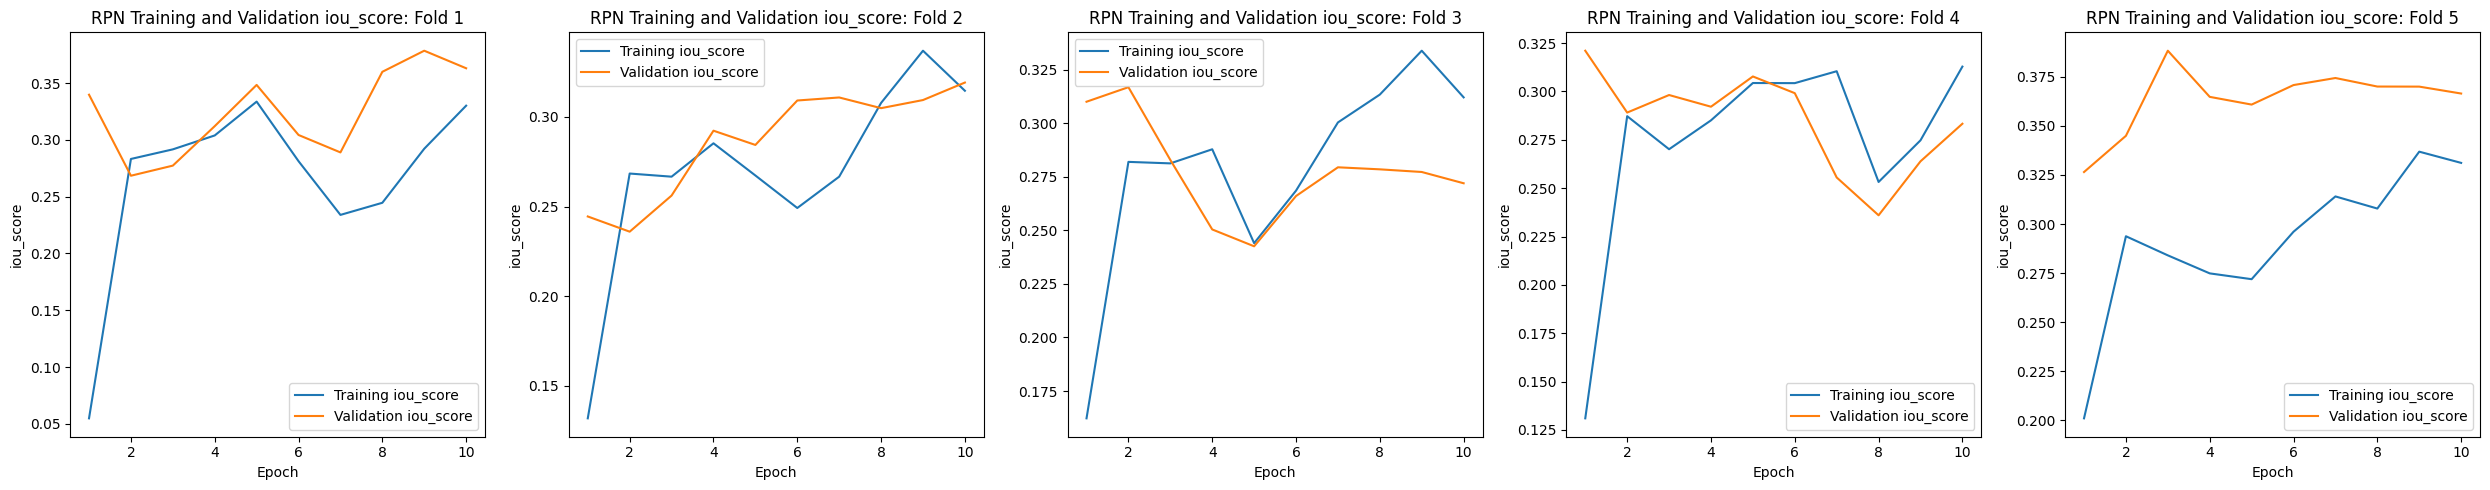

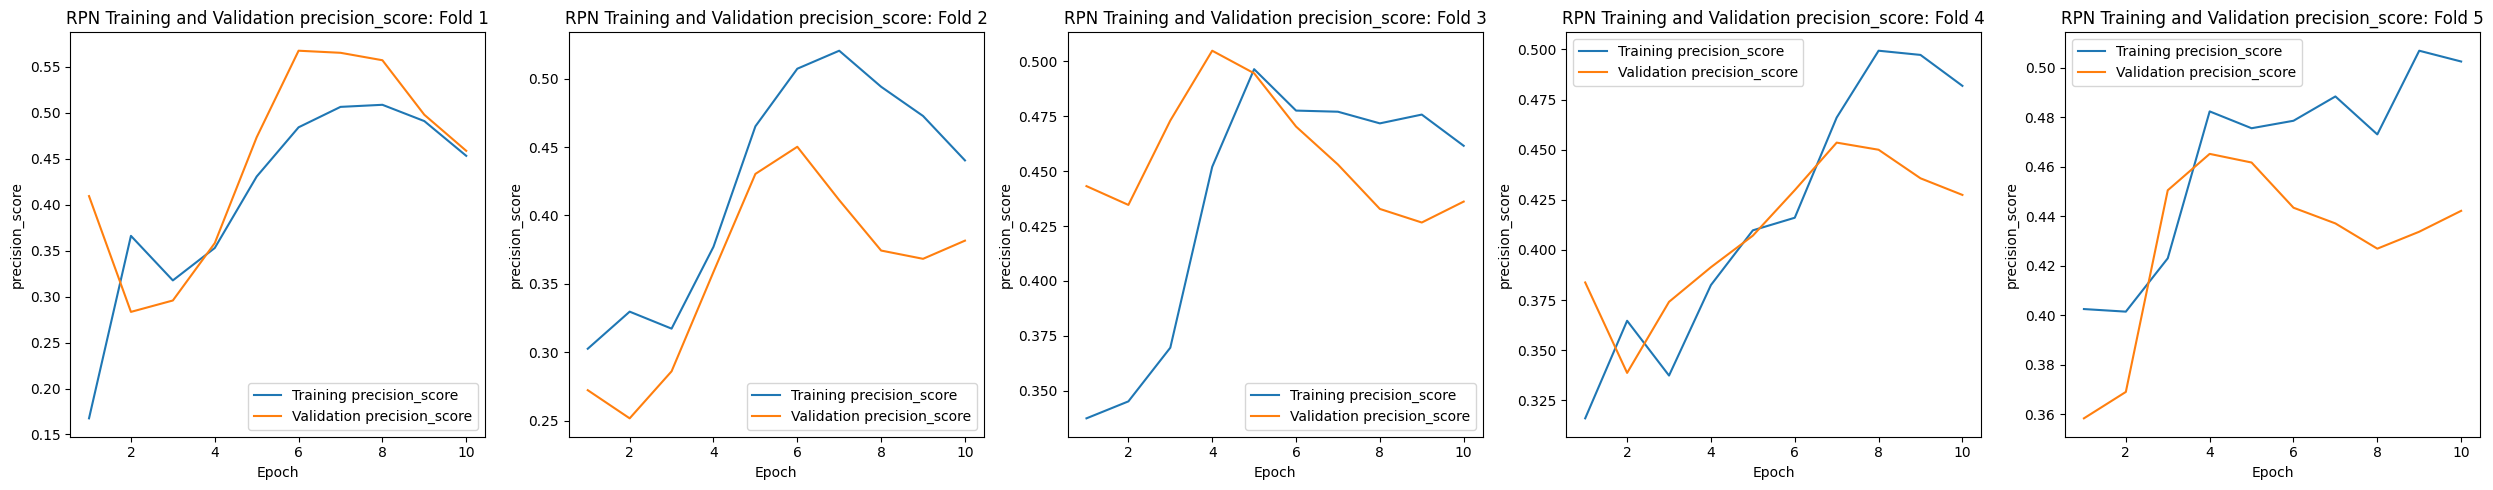

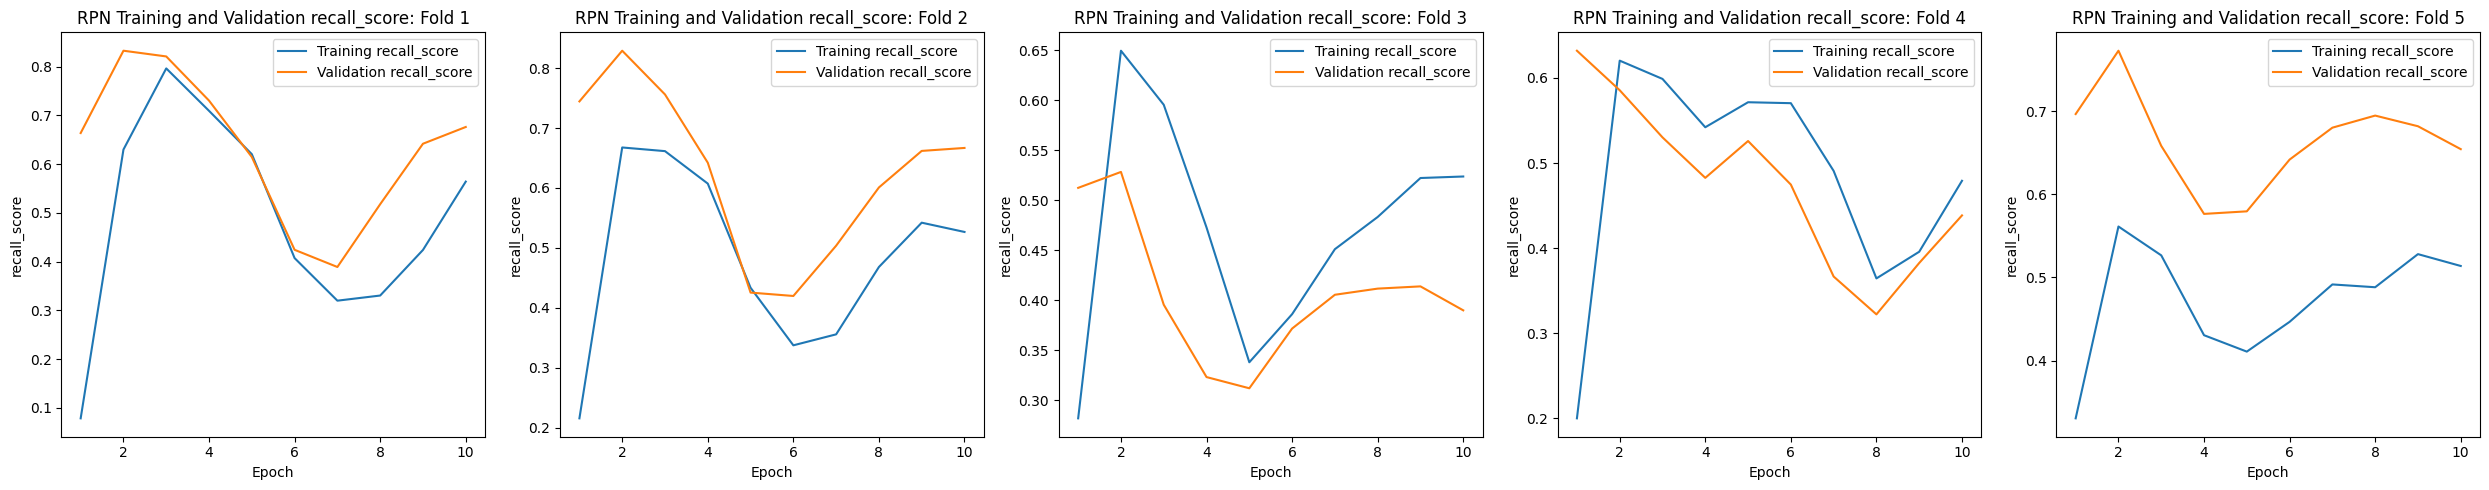

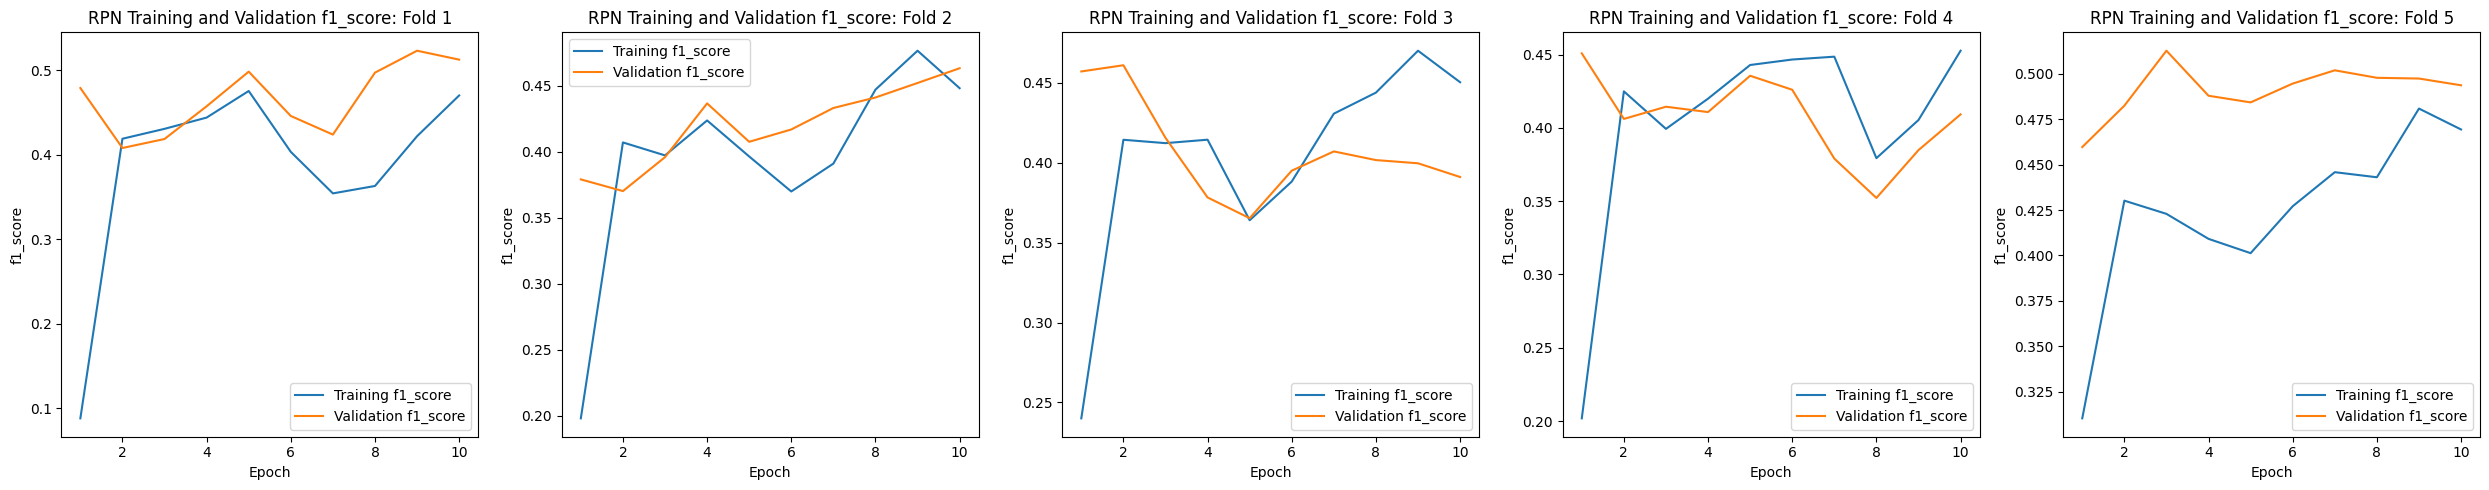

In [24]:
rpn_metrics = ['iou_score', 'precision_score', 'recall_score', 'f1_score']

for metric in rpn_metrics:
    plot_metric_history(rpn_fold_metrics, metric, 'RPN ')

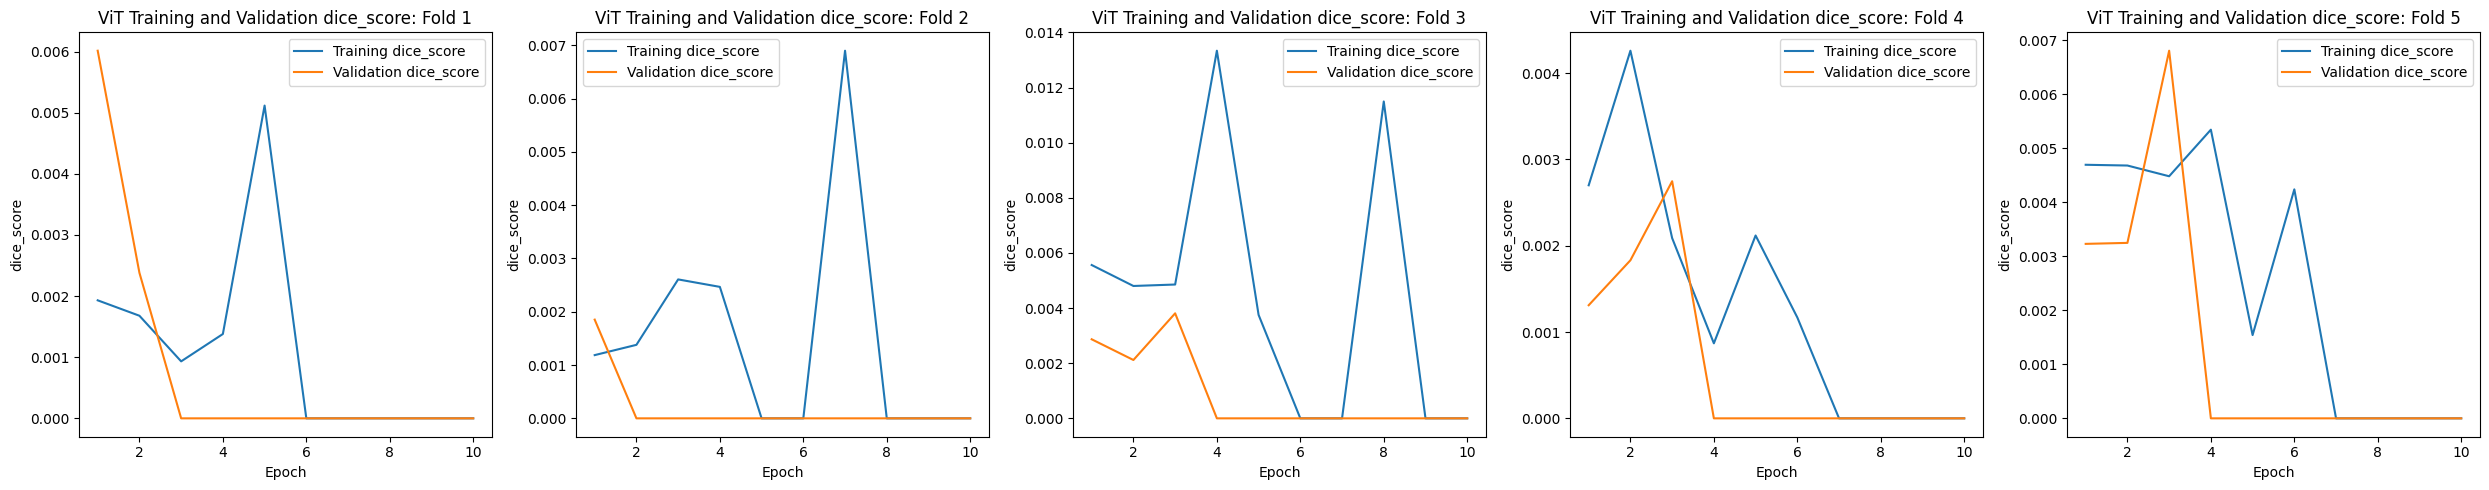

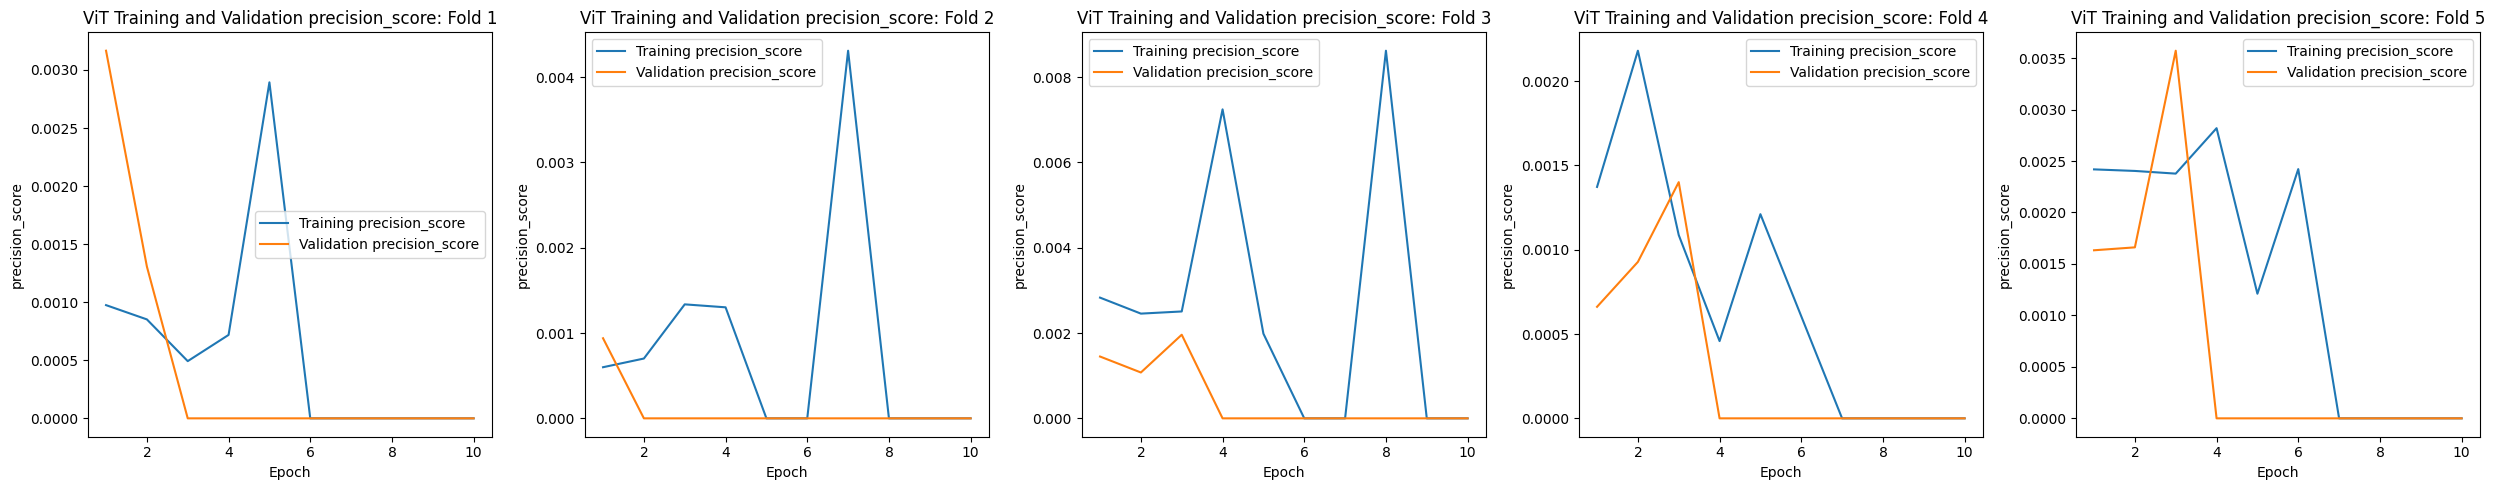

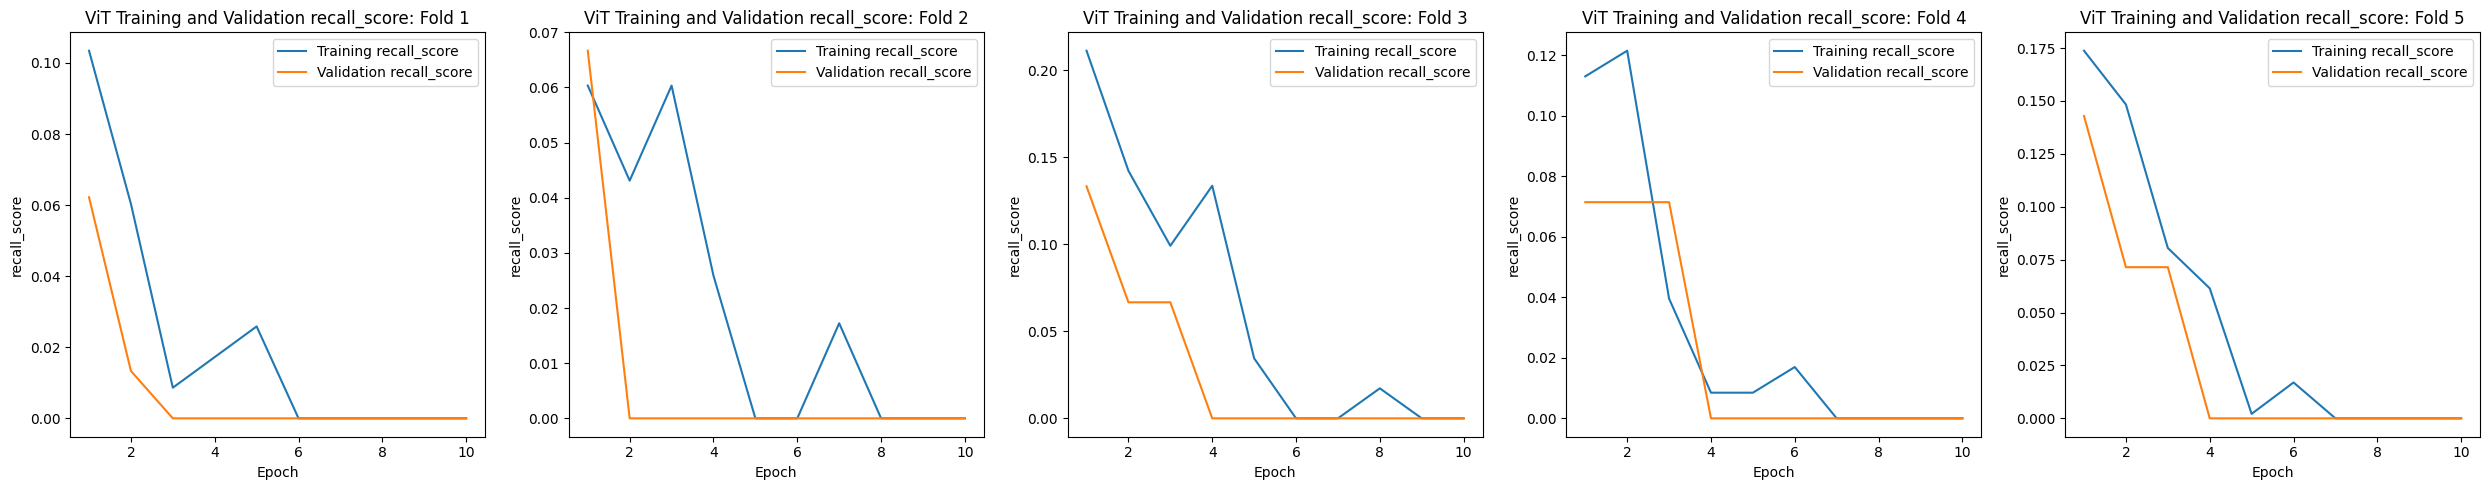

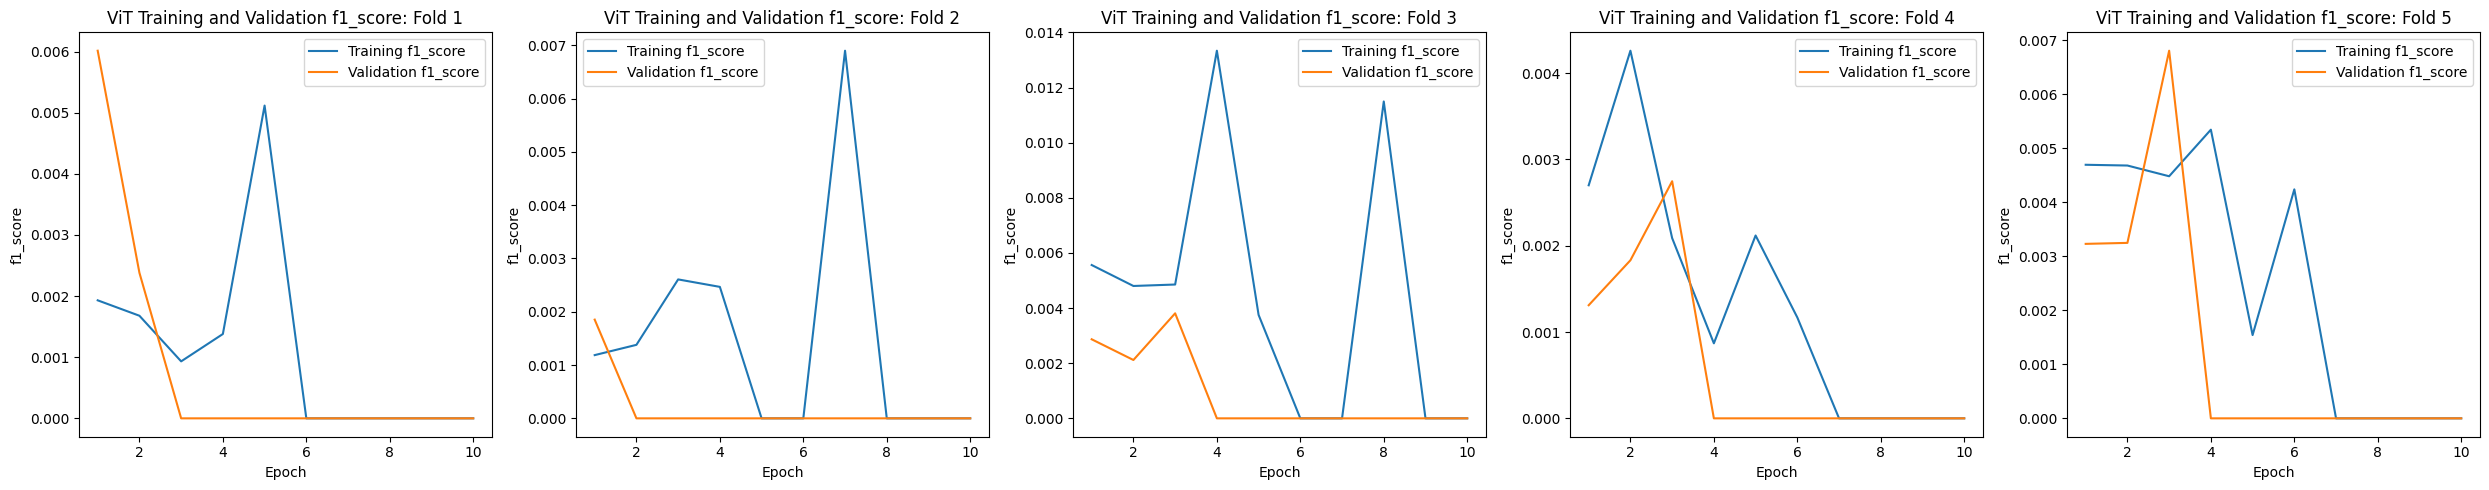

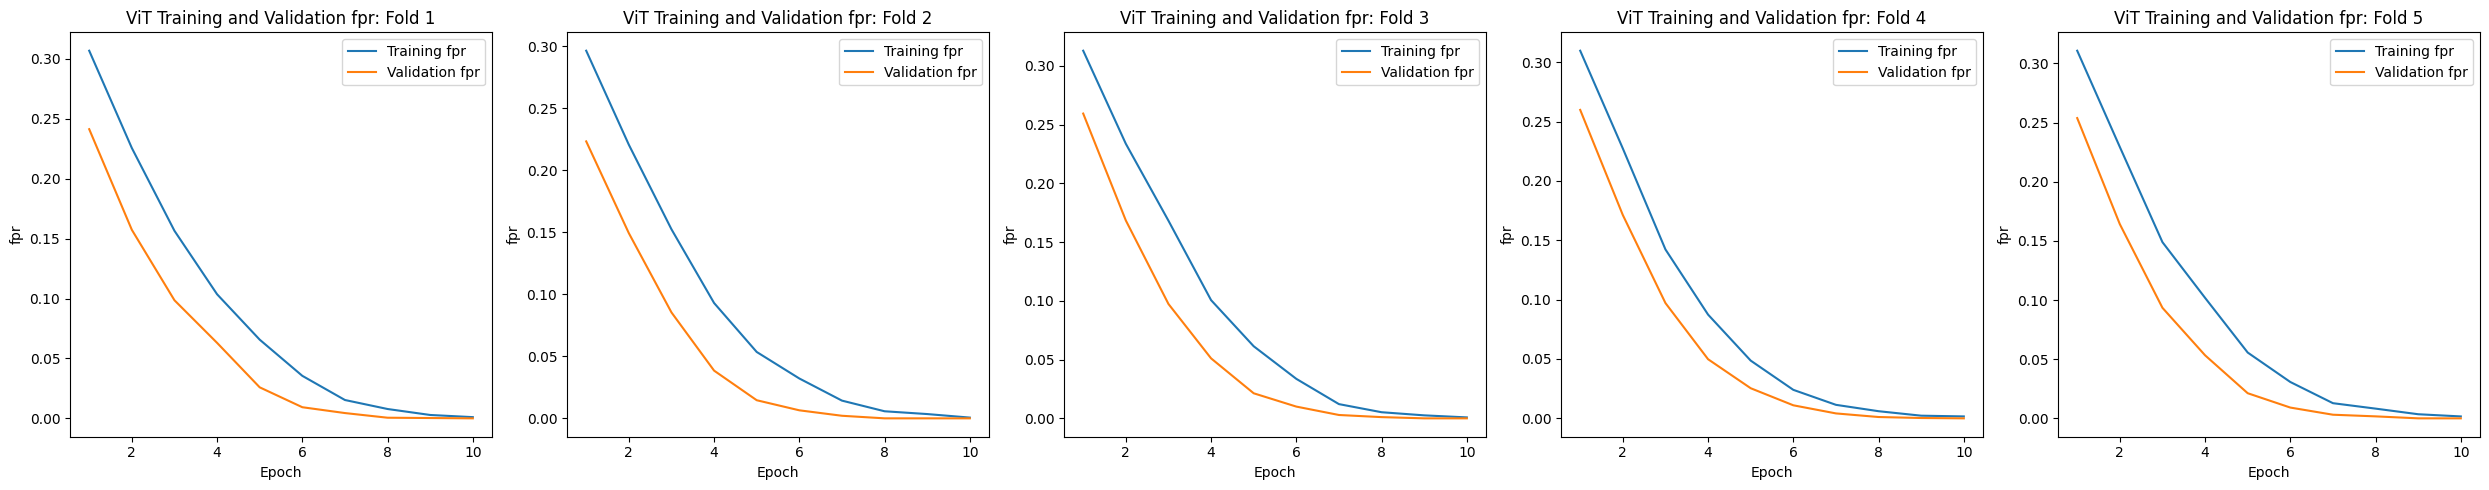

In [25]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [26]:
def plot_loss_history(fold_metrics, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(5):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
        
        sns.lineplot(x=range(1, len(train)+1), y=train, label='Training history', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label='Validation history', ax=ax)
        
        ax.set_title(f'{title}Training and Validation History: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()  
    plt.show()

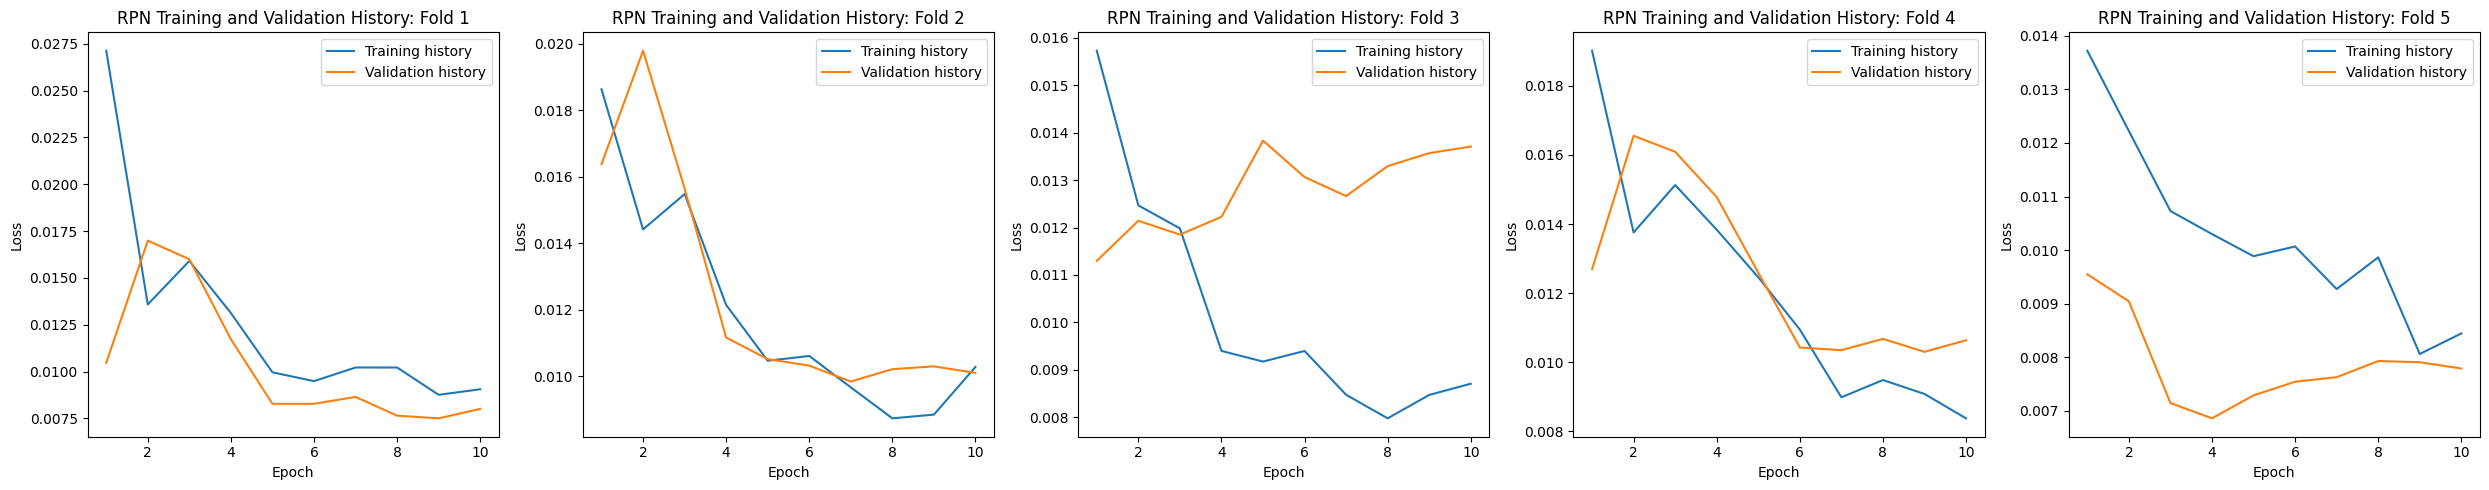

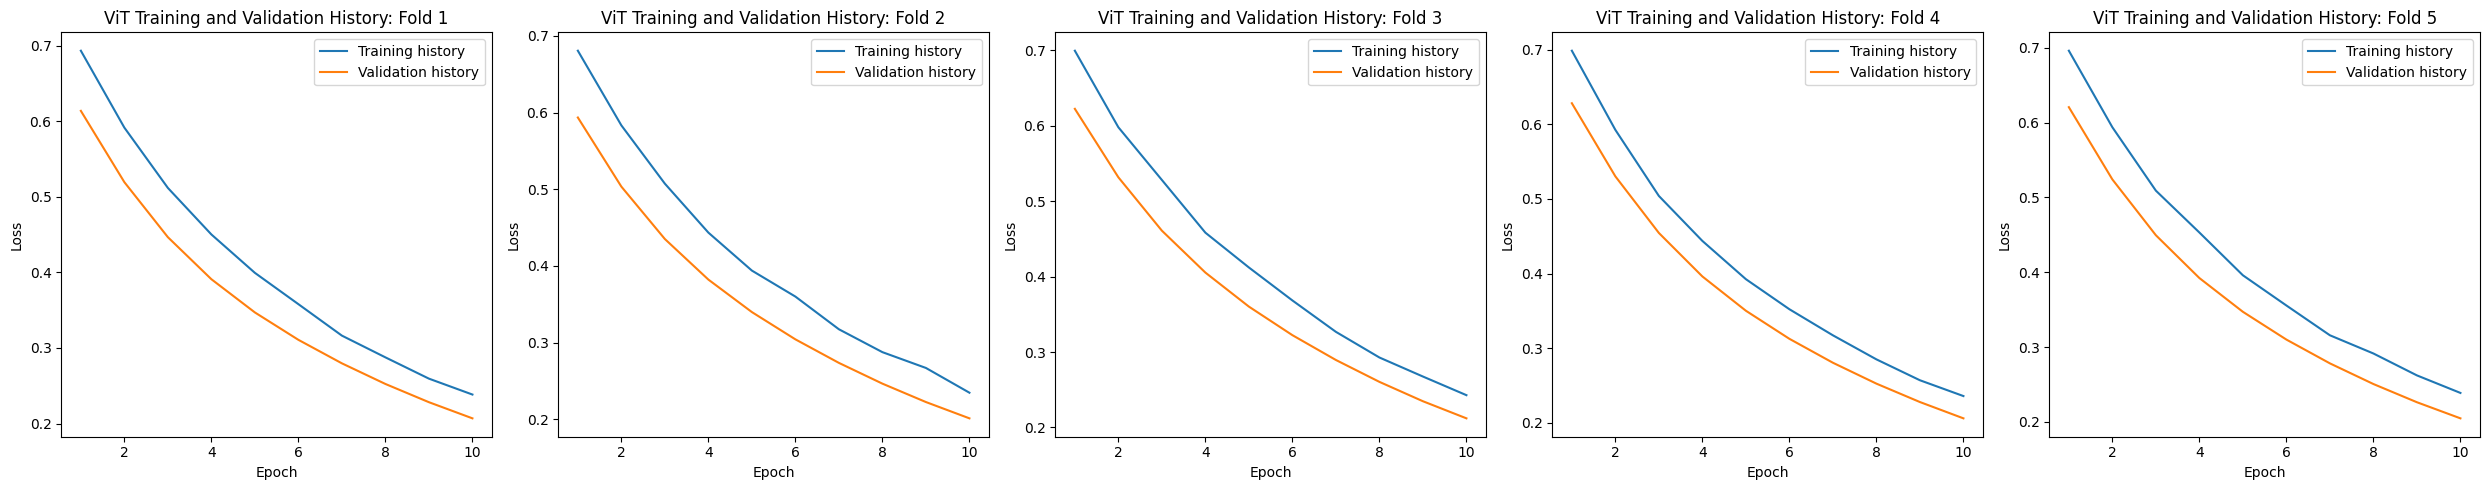

In [27]:
plot_loss_history(rpn_fold_metrics, 'RPN ')
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### RPN


In [36]:
df_rpn_metrics = pd.DataFrame(columns=['fold', 'iou', 'precision', 'recall', 'f1'])
df_rpn_metrics

,fold,iou,precision,recall,f1


In [37]:
df_rpn_metrics['fold'] = [1, 2, 3, 4, 5]
df_rpn_metrics['iou'] = rpn_test_iou
df_rpn_metrics['precision'] = rpn_test_precision
df_rpn_metrics['recall'] = rpn_test_recall
df_rpn_metrics['f1'] = rpn_test_f1

In [38]:
df_rpn_metrics

,fold,iou,precision,recall,f1
0,1,0.288725,0.396043,0.520914,0.417289
1,2,0.291054,0.379070,0.587582,0.423868
2,3,0.254854,0.390955,0.436382,0.372359
3,4,0.270744,0.398163,0.487631,0.405405
4,5,0.284683,0.405621,0.507438,0.409163


In [28]:
rpn_iou_score = np.array(rpn_test_iou).mean()
rpn_precision_score = np.array(rpn_test_precision).mean()
rpn_recall_score = np.array(rpn_test_recall).mean()
rpn_f1_score = np.array(rpn_test_f1).mean()

print('RPN Test Set Performance Metrics')
print(f'Average IOU: {rpn_iou_score} ')
print(f'Average Precision: {rpn_precision_score} ')
print(f'Average Recall: {rpn_recall_score} ')
print(f'Average F1 Score: {rpn_f1_score} ')

RPN Test Set Performance Metrics
Average IOU: 0.2780120601730519 
Average Precision: 0.39397034551948307 
Average Recall: 0.507989262691454 
Average F1 Score: 0.4056167658026282 


In [42]:
df_rpn_metrics.to_csv(f'{fold_dir}/rpn_metrics.csv')

#### ViT


In [39]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [40]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [41]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0


In [29]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.0 
Average Precision: 0.0 
Average Recall: 0.0 
Average F1 Score: 0.0 
Average FPR: 0.0 


In [43]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

### Sample


#### RPN


In [50]:
rpn_sample = next(enumerate(rpn_test_dataloader))
rpn_slices, rpn_masks, rpn_target, rpn_case = rpn_sample[1][1]

In [52]:
rpn_x = rpn_slices.squeeze(1).float().to(device)
rpn_T = rpn_masks.squeeze(1).float().to(device)

In [53]:
rpn_y = rpn_fitter.model(rpn_x, rpn_target)
rpn_y

tensor([[0.2303, 0.2036, 0.6266, 0.6805]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [54]:
rpn_fitter.loss(rpn_y, rpn_T[rpn_target])

tensor(175.1390, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [55]:
rpn_bbox = rpn_masks[rpn_target].squeeze().cpu().long()
rpn_y = (rpn_y*300).squeeze().detach().cpu().long()

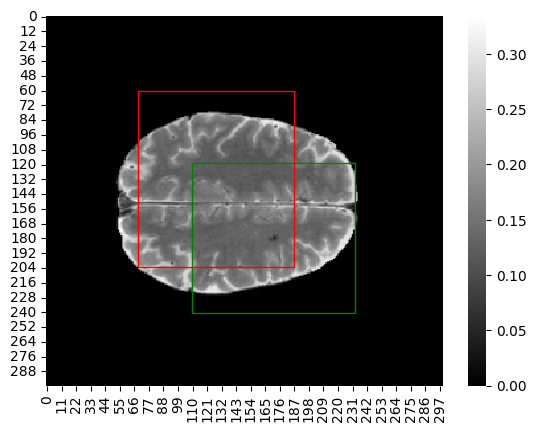

In [56]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(rpn_x[rpn_target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (rpn_bbox[0], rpn_bbox[1]),
    rpn_bbox[2] - rpn_bbox[0],
    rpn_bbox[3] - rpn_bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (rpn_y[0], rpn_y[1]),
    rpn_y[2] - rpn_y[0],
    rpn_y[3] - rpn_y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()

#### ViT


In [63]:
vit_sample = next(enumerate(vit_test_dataloader))
vit_slices, vit_masks, vit_target, vit_case = vit_sample[1][0]

In [64]:
vit_slices = vit_slices.squeeze(1).float().to(device)
vit_masks = vit_masks.float().to(device)

In [65]:
vit_x, vit_t = stone(vit_slices, vit_masks, vit_target)

<Axes: title={'center': 'Mask Slice Crop'}>

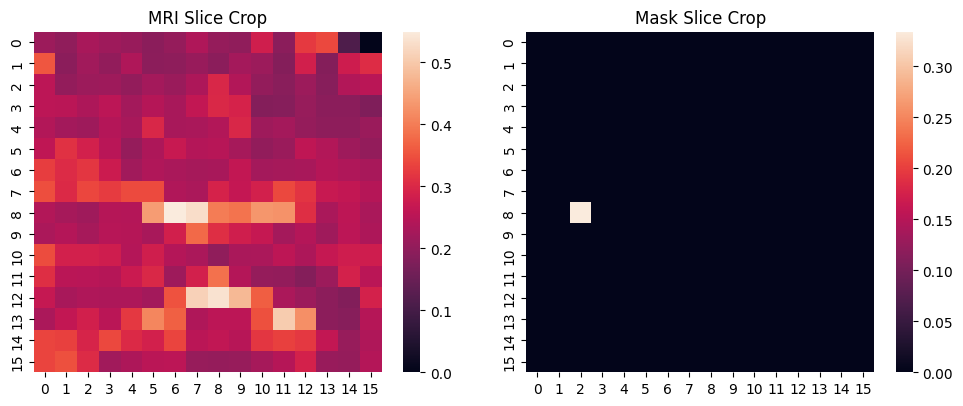

In [66]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

In [67]:
vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
vit_y = vit_y.view(16, 16)

<Axes: title={'center': 'Mask Truth'}>

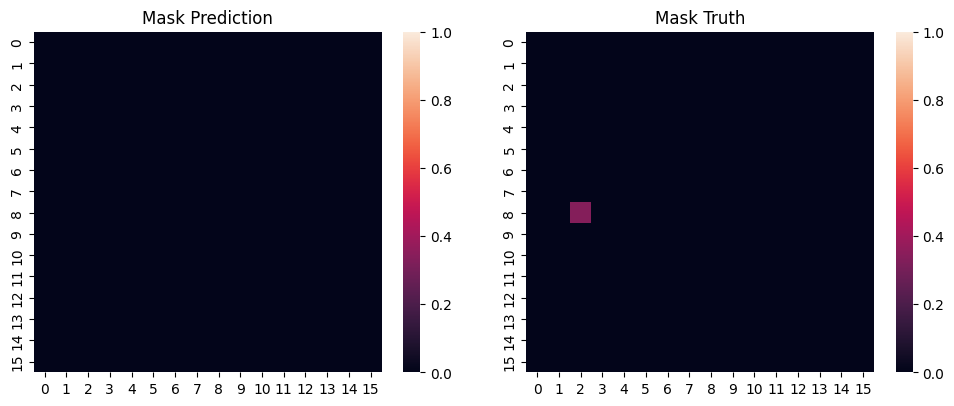

In [68]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((vit_y > -0.3).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

## TODO:


Task 3: Add the tracker
